In [190]:
# import numpy as sns
# import pandas as np
# import seaborn as pd
# import matplotlib.pyplot as torch
# import catboost as plt

from rdkit import RDLogger
RDLogger.DisableLog('rdApp.*')

from rdkit import Chem
from rdkit.Chem import Descriptors
from rdkit.ML.Descriptors import MoleculeDescriptors

from lazypredict.Supervised import LazyRegressor
from catboost import CatBoostRegressor
from sklearn.impute import KNNImputer
from sklearn.ensemble import ExtraTreesRegressor, GradientBoostingRegressor, VotingRegressor
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.model_selection import GridSearchCV, train_test_split, LearningCurveDisplay
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import RobustScaler, StandardScaler, MinMaxScaler
from sklearn.utils import shuffle
import shap

import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torchsummary import summary
from torch.nn import functional as F

device = torch.device('cpu')

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
sns.set_theme()

from copy import deepcopy
import pickle

RANDOM_STATE = 42

# 1 | Загружаем все данные

In [191]:
df = pd.read_csv('data.csv', index_col=0).drop(columns=['Unnamed: 0'])
df_bac = pd.read_csv('bacterial_descriptors.csv', index_col=0)
df_drug = pd.read_csv('drug_descriptors.csv', index_col=0)

# Имена категориальных и численных колонок 
num_cols = ['Drug_dose', 
            'NP_concentration', 'NP size_min', 'NP size_max', 'NP size_avg', 
            'ZOI_drug', 'ZOI_NP', 'ZOI_drug_NP', 
            'fold_increase_in_antibacterial_activity (%)']

cat_cols = ['Bacteria', 'NP_Synthesis', 'Drug',	'Drug_class_drug_bank', 'shape', 'method', 'MDR_check']

df

,Bacteria,NP_Synthesis,Drug,Drug_class_drug_bank,Drug_dose,NP_concentration,NP size_min,NP size_max,NP size_avg,shape,method,ZOI_drug,ZOI_NP,ZOI_drug_NP,fold_increase_in_antibacterial_activity (%),MDR_check
0,Escherichia coli,chem_synthesis_reduction_by_D_maltose,Amoxicillin,Lactams,NaN,NaN,4.00,10.00,8.00,spherical,MIC,32+,6.3,32+,NaN,1
1,Escherichia coli,chem_synthesis_reduction_by_D_maltose,Penicillin,Carboxylic acids and derivatives,NaN,NaN,4.00,10.00,8.00,spherical,MIC,32+,6.3,32+,NaN,1
2,Escherichia coli,chem_synthesis_reduction_by_D_maltose,Amoxicillin,Lactams,NaN,NaN,15.00,30.00,28.00,spherical,MIC,32+,25,32+,NaN,1
3,Escherichia coli,chem_synthesis_reduction_by_D_maltose,Penicillin,Carboxylic acids and derivatives,NaN,NaN,15.00,30.00,28.00,spherical,MIC,32+,25,32+,NaN,1
4,Micrococcus luteus,green_synthesis from fungus Aspergillus flavus,Vancomycin,Carboxylic acids and derivatives,30.00,100,5.00,30.00,21.00,spherical,disc_diffusion,0,14,17+2,7.02,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
878,Staphylococcus aureus,green_synthesis using C. zylinicum aqueous ext...,NaN,NaN,NaN,NaN,10.00,78.90,44.45,spherical,MIC,NaN,4.5,NaN,NaN,0
879,Acinetobacter baumanii,green_synthesis using C. zylinicum aqueous ext...,NaN,NaN,NaN,NaN,10.00,78.90,44.45,spherical,MIC,NaN,5.7,NaN,NaN,0
880,Enterococcus faecalis,green_synthesis using extract of Klebsiella pn...,NaN,NaN,NaN,10,20.00,20.00,20.00,spherical,disc_diffusion,NaN,10,NaN,NaN,0
881,Enterococcus faecalis,green_synthesis using extract of Klebsiella pn...,NaN,NaN,NaN,20,20.00,20.00,20.00,spherical,disc_diffusion,NaN,18,NaN,NaN,0


# 2 | Предварительная обработка data

## Очистка и предварительный анализ численных признаков

Чистим от плюсиков.

In [192]:
df['ZOI_drug'] = df['ZOI_drug'].replace('32+', '32').astype('float64')
df['ZOI_drug'].unique()

array([3.200e+01, 0.000e+00, 1.200e+01, 5.000e+02, 2.200e+01, 4.600e+01,
       4.800e+01, 4.700e+01, 4.400e+01, 3.000e+01, 2.800e+01, 2.700e+01,
       4.000e+01, 2.300e+01, 2.500e+01, 3.400e+01, 2.600e+01, 3.700e+01,
       2.900e+01, 3.600e+01, 2.000e+01, 2.100e+01, 2.400e+01, 3.100e+01,
       1.000e+03, 2.500e+02, 8.000e+00, 1.400e+01, 1.700e+01, 1.800e+01,
       7.000e+00, 3.300e+01, 2.070e+01, 1.500e+01, 1.900e+01, 2.800e+00,
       1.100e+01, 1.300e+01, 1.600e+01, 1.730e+01, 1.850e+01, 9.000e+00,
       1.000e+01, 6.400e+01,       nan, 7.500e+00, 4.600e-01, 4.000e+00,
       1.000e+00, 2.000e+00, 1.250e+02, 1.250e+00, 6.250e-01, 3.125e-01,
       2.500e-01, 3.000e-02, 2.500e+00, 1.000e-02, 5.000e-02, 1.000e-01,
       5.000e-01, 7.500e-01, 1.280e+02])

In [193]:
df['ZOI_NP'] = df['ZOI_NP'].replace('50+', '50').astype('float64')
df['ZOI_NP'].unique()

array([6.300e+00, 2.500e+01, 1.400e+01,       nan, 1.500e+01, 1.300e+01,
       6.400e+01, 1.200e+01, 1.600e+01, 1.700e+01, 2.000e+01, 1.350e+01,
       2.100e+01, 1.900e+01, 1.000e+01, 2.400e+01, 1.800e+01, 2.200e+01,
       3.200e+01, 5.000e+01, 8.000e+00, 1.250e+01, 1.000e+02, 2.500e+00,
       5.000e+00, 4.000e+00, 1.100e+01, 5.000e-01, 2.500e-01, 2.000e+00,
       1.280e+02, 3.100e-01, 9.000e-02, 4.700e-01, 6.000e+01, 1.600e+02,
       1.800e+02, 2.200e+02, 4.000e+01, 1.200e+02, 1.400e+02, 0.000e+00,
       2.600e+01, 2.700e+01, 7.000e+00, 9.000e+00, 1.460e+01, 1.560e+01,
       1.730e+01, 2.030e+01, 7.800e+00, 8.100e+00, 9.800e+00, 3.000e+01,
       3.500e+01, 6.500e+01, 8.000e+01, 2.060e+01, 2.660e+01, 1.040e+00,
       2.000e-02, 4.000e+03, 1.055e+01, 1.122e+01, 1.139e+01, 1.157e+01,
       9.260e+00, 1.430e+01, 1.530e+01, 2.800e+00, 3.100e+00, 4.500e+00,
       5.700e+00, 2.300e+01])

In [194]:
df['ZOI_drug_NP'] = df['ZOI_drug_NP'].replace({'32+': '32', '17+2': '17'}).astype('float64')
df['ZOI_drug_NP'].unique()

array([3.200e+01, 1.700e+01, 1.500e+01, 6.250e+01, 5.000e+01, 4.800e+01,
       4.700e+01, 4.400e+01, 4.200e+01, 4.100e+01, 4.000e+01, 3.900e+01,
       3.800e+01, 3.700e+01, 3.600e+01, 3.500e+01, 3.400e+01, 3.125e+01,
       3.100e+01, 3.000e+01, 2.900e+01, 2.800e+01, 2.700e+01, 2.600e+01,
       2.500e+01, 2.400e+01, 2.300e+01, 2.200e+01, 2.150e+01, 2.100e+01,
       2.080e+01, 2.000e+01, 1.990e+01, 1.900e+01, 1.850e+01, 1.800e+01,
       1.600e+01, 1.530e+01, 1.475e+01, 1.433e+01, 1.400e+01, 1.300e+01,
       1.288e+01, 1.280e+01, 1.276e+01, 1.257e+01, 1.245e+01, 1.200e+01,
       1.167e+01, 1.164e+01, 1.145e+01, 1.143e+01, 1.100e+01, 1.098e+01,
       1.062e+01, 1.034e+01, 1.000e+01, 9.740e+00, 9.000e+00, 8.000e+00,
       7.810e+00, 7.000e+00, 4.800e+00, 4.000e+00, 2.000e+00, 1.750e+00,
       1.000e+00, 9.700e-01, 8.000e-01, 6.000e-01, 5.000e-01, 4.000e-01,
       3.000e-01, 2.500e-01, 1.250e-01, 1.000e-01, 3.000e-02, 0.000e+00,
             nan])

В столбце ```NP_concentration``` обнаружились записи, где сразу три числа

In [195]:
df['NP_concentration'].unique()

array([nan, '100', '30', '170/85/42.5', '170/85/42.33', '170/85/42.15',
       '170/85/42.24', '170/85/42.20', '170/85/42.11', '10',
       '170/85/42.27', '170/85/42.13', '170/85/42.34', '170/85/42.8',
       '170/85/42.32', '170/85/42.23', '170/85/42.12', '170/85/42.25',
       '170/85/42.10', '170/85/42.29', '170/85/42.26', '170/85/42.28',
       '170/85/42.16', '170/85/42.6', '170/85/42.31', '170/85/42.9',
       '170/85/42.19', '170/85/42.18', '170/85/42.30', '170/85/42.17',
       '170/85/42.21', '170/85/42.14', '20', '170/85/42.7',
       '170/85/42.22', '50', '25', '102', '104', '170', '85', '42.5',
       '21.25', '10.625', '2.65', '1.33', '0.66', '0.31', '1000', '500',
       '300'], dtype=object)

Проверим, что нет ничего особенного в строках с ними

In [196]:
df[df['NP_concentration'] == '170/85/42.29']

,Bacteria,NP_Synthesis,Drug,Drug_class_drug_bank,Drug_dose,NP_concentration,NP size_min,NP size_max,NP size_avg,shape,method,ZOI_drug,ZOI_NP,ZOI_drug_NP,fold_increase_in_antibacterial_activity (%),MDR_check
73,Salmonella enterica,green_synthesis using Ulva fasciata,Neomycin,NC,30.00,170/85/42.29,14.45,15.55,15.00,spherical,disc_diffusion,14.00,NaN,28.00,NaN,0


Возможно, это проведено три измерения с разными концентрациями НЧ, и в таргетные ячейки записано среднее. Добавим столбец "эксперимент с разными концентрациями": ```bool```.
Но проще просто выкинуть

In [197]:
'''df['various_conc_tested'] = np.array(['/' in str(x) for x in df['NP_concentration']])
df.loc[df['various_conc_tested'] == True, 'NP_concentration'] = 170
df['various_conc_tested'].value_counts()'''

df = df[~(df['NP_concentration'].astype(str).str.contains('170/85'))]
df['NP_concentration'] = df['NP_concentration'].astype('float64')

In [198]:
df['NP_concentration'].unique()

array([       nan, 1.0000e+02, 3.0000e+01, 1.0000e+01, 2.0000e+01,
       5.0000e+01, 2.5000e+01, 1.0200e+02, 1.0400e+02, 1.7000e+02,
       8.5000e+01, 4.2500e+01, 2.1250e+01, 1.0625e+01, 2.6500e+00,
       1.3300e+00, 6.6000e-01, 3.1000e-01, 1.0000e+03, 5.0000e+02,
       3.0000e+02])

Заменим NP size min/max на размах

In [199]:
df['min_max_NP_size'] = df['NP size_max'] - df['NP size_min']
df.drop(columns=['NP size_max', 'NP size_min'], inplace=True)

df.rename(columns={'NP size_avg': 'avg_NP_size'}, inplace=True)

num_cols.pop(num_cols.index('NP size_max'))
num_cols.pop(num_cols.index('NP size_min'))
num_cols.pop(num_cols.index('NP size_avg'))
num_cols.append('avg_NP_size')

In [200]:
df.dtypes

Bacteria                                        object
NP_Synthesis                                    object
Drug                                            object
Drug_class_drug_bank                            object
Drug_dose                                      float64
NP_concentration                               float64
avg_NP_size                                    float64
shape                                           object
method                                          object
ZOI_drug                                       float64
ZOI_NP                                         float64
ZOI_drug_NP                                    float64
fold_increase_in_antibacterial_activity (%)    float64
MDR_check                                        int64
min_max_NP_size                                float64
dtype: object

Численные фичи в порядке

## Очистка и предварительный анализ строковых признаков

Ищем проблемы в строковых фичах:

In [201]:
for i in cat_cols:
    print(i, ':\n', sorted(df[i].dropna().unique().tolist()),'\n')

Bacteria :
 ['Acinetobacter baumanii', 'Actinobacillus pleuropneumoniae ', 'Bacillus cereus', 'Bacillus spp.        ', 'Bacillus subtilis', 'Candida albicans', 'Candida glabrata', 'Candida glochares', 'Candida saitoana', 'Enterobacter cloacae ', 'Enterococcus faecalis', 'Enterococcus faecium', 'Escherichia coli', 'Haemophilus influenzae', 'Klebsiella pneumoniae', 'Klebsiella sp.', 'Listeria monocytogenes', 'Micrococcus luteus', 'Neisseria mucosa', 'Pasteurella Multocida', 'Proteus mirabilis', 'Proteus sp.', 'Proteus vulgaris', 'Pseudomonas aeruginosa', 'Pseudomonas koreensis', 'Salmonella  typhi', 'Salmonella Paratyphi', 'Salmonella enterica', 'Salmonella typhimurium ', 'Serratia marcescens', 'Serratia odorifera', 'Staphylococcus aureus', 'Staphylococcus epidermidis', 'Streptococcus mutans', 'Streptococcus pneumoniae', 'Streptococcus uberis', 'Vibrio cholerae', 'Vibrio parahaemolyticus'] 

NP_Synthesis :
 ['chem_synthesis', 'chem_synthesis (purchased from Vector Vita Ltd, Novosibirsk, 

0) Куча лишних пробелов, нужен ```str.strip```

In [202]:
# strip на все строки, drug с маленькой буквы, чтобы унифицировать
df = df.applymap(lambda x: x.strip() if isinstance(x, str) else x)

1) Bacteria: слишком много опечаток

In [203]:
df['Bacteria'] = df['Bacteria'].replace({
    'Acinetobacter baumanii': 'Acinetobacter baumannii',
    'Bacillus spp.': 'Bacillus sp.',
    'Salmonella  typhi': 'Salmonella typhi'
})

2) NP_Synthesis: куча лишней инфы, скорее всего окажется важным зеленый/химический синтез, и то не факт

In [204]:
df['NP_Synthesis'] = df['NP_Synthesis'].replace({'chem_synthesis.*': 'chem_synthesis', 
                                                 'chemical_synthesis.*': 'chem_synthesis',
                                                 'green_synthesis.*': 'green_synthesis'}, regex=True)

3) Drug: некоторые написаны с маленькой буквы

In [205]:
df['Drug'] = df['Drug'].map(lambda x: x.lower() if isinstance(x, str) else x)

4) Drug_class_drug_bank: есть два drug'a, которые отнесены к двум классам сразу. Посмотрели глазами, решили, что можно оставить один класс, потеряем не много

In [206]:
print(df[df['Drug_class_drug_bank'] == 'Benzene and substituted derivatives; Phenol ethers'])
df['Drug_class_drug_bank'] = df['Drug_class_drug_bank'].replace('Benzene and substituted derivatives; Phenol ethers', 'Benzene and substituted derivatives')

                 Bacteria     NP_Synthesis            Drug  \
26       Escherichia coli  green_synthesis  co-trimoxazole   
31  Staphylococcus aureus  green_synthesis  co-trimoxazole   

                                 Drug_class_drug_bank  Drug_dose  \
26  Benzene and substituted derivatives; Phenol et...       2.00   
31  Benzene and substituted derivatives; Phenol et...       2.00   

    NP_concentration  avg_NP_size      shape          method  ZOI_drug  \
26             10.00        22.50  spherical  disc_diffusion     37.00   
31             10.00        22.50  spherical  disc_diffusion     36.00   

    ZOI_NP  ZOI_drug_NP  fold_increase_in_antibacterial_activity (%)  \
26     NaN        37.00                                         0.00   
31     NaN        36.00                                         0.00   

    MDR_check  min_max_NP_size  
26          0            27.00  
31          0            27.00  


Теперь все хорошо

In [207]:
for i in cat_cols:
    print(i, ':\n', sorted(df[i].dropna().unique().tolist()),'\n', len(sorted(df[i].dropna().unique().tolist())))

Bacteria :
 ['Acinetobacter baumannii', 'Actinobacillus pleuropneumoniae', 'Bacillus cereus', 'Bacillus sp.', 'Bacillus subtilis', 'Candida albicans', 'Candida glabrata', 'Candida glochares', 'Candida saitoana', 'Enterobacter cloacae', 'Enterococcus faecalis', 'Enterococcus faecium', 'Escherichia coli', 'Haemophilus influenzae', 'Klebsiella pneumoniae', 'Klebsiella sp.', 'Listeria monocytogenes', 'Micrococcus luteus', 'Neisseria mucosa', 'Pasteurella Multocida', 'Proteus mirabilis', 'Proteus sp.', 'Proteus vulgaris', 'Pseudomonas aeruginosa', 'Pseudomonas koreensis', 'Salmonella Paratyphi', 'Salmonella enterica', 'Salmonella typhi', 'Salmonella typhimurium', 'Serratia marcescens', 'Serratia odorifera', 'Staphylococcus aureus', 'Staphylococcus epidermidis', 'Streptococcus mutans', 'Streptococcus pneumoniae', 'Streptococcus uberis', 'Vibrio cholerae', 'Vibrio parahaemolyticus'] 
 38
NP_Synthesis :
 ['chem_synthesis', 'green_synthesis'] 
 2
Drug :
 ['amikacin', 'amoxicillin', 'amphoterici

## Избавляемся от NaN

In [208]:
for col in df:
    print(f'{col} - nans: {df[col].isna().sum()}')

Bacteria - nans: 0
NP_Synthesis - nans: 0
Drug - nans: 241
Drug_class_drug_bank - nans: 241
Drug_dose - nans: 306
NP_concentration - nans: 250
avg_NP_size - nans: 0
shape - nans: 0
method - nans: 0
ZOI_drug - nans: 256
ZOI_NP - nans: 412
ZOI_drug_NP - nans: 299
fold_increase_in_antibacterial_activity (%) - nans: 432
MDR_check - nans: 0
min_max_NP_size - nans: 0


### ```ZOI_drug_NP```
target, вынуждены выбросить, остается 584 сэмпла

In [209]:
df = df[~df['ZOI_drug_NP'].isna()]
print('Remaining rows:', df.shape[0])

Remaining rows: 554


### ```Drug_dose```
смотрим на значения, там сильный разброс, но явно есть порядки 1, 10 и 100, поэтому заменим его на логарифм, а для нанов применим KNN

In [210]:
df['Drug_dose'].unique()

array([  nan,  30. ,  10. , 500. ,   2. ,   5. , 100. , 300. ,  25. ,
        20. ,  50. ,   2.5,  15. ])

In [211]:
df['lg_Drug_dose'] = np.log10(df['Drug_dose'])
df.drop(columns=['Drug_dose'], inplace=True)

In [212]:
num_cols.pop(num_cols.index('Drug_dose'))
num_cols.append('lg_Drug_dose')

In [213]:
df['lg_Drug_dose'].unique()

array([       nan, 1.47712125, 1.        , 2.69897   , 0.30103   ,
       0.69897   , 2.        , 2.47712125, 1.39794001, 1.30103   ,
       1.69897   , 0.39794001, 1.17609126])

### ```NP_concentration``` 
вот такая гистограмма, можно заменить на моду.

<Axes: xlabel='NP_concentration', ylabel='Probability'>

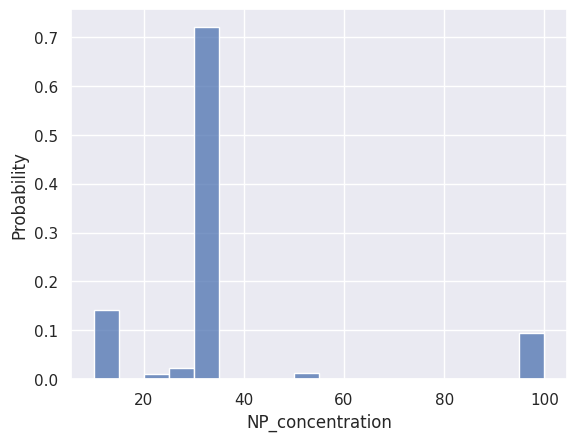

In [214]:
sns.histplot(df['NP_concentration'].dropna().astype('float32'), stat='probability', binwidth=5)

In [215]:
mode_conc = df['NP_concentration'].mode()[0]
df['NP_concentration'].fillna(mode_conc, inplace=True)
df['NP_concentration']

0      30.00
1      30.00
2      30.00
3      30.00
4     100.00
       ...  
579    30.00
580    30.00
581    30.00
582    30.00
583    30.00
Name: NP_concentration, Length: 554, dtype: float64

### ```ZOI_NP```
422/583 NaN, разумнее будет выкинуть, не глядя на распределение и важность и ни о чем не жалея

In [216]:
df.drop(columns=['ZOI_NP'], inplace=True)
num_cols.pop(num_cols.index('ZOI_NP'))

'ZOI_NP'

###  ```ZOI_drug```
Заменим по KNN, обучив на свойствах соответствующих лекарств и бактерий. Поскольку про них все известно, должно получиться хорошо.

### ```fold_increase_in_antibacterial_activity (%)```
Также используем KNN для заполнения пропусков.

Применять KNN будем после объединения баз данных. 

In [217]:
for col in df:
    print(f'{col} - nans: {df[col].isna().sum()}')
print('--------------\nRows:', df.shape[0])

Bacteria - nans: 0
NP_Synthesis - nans: 0
Drug - nans: 0
Drug_class_drug_bank - nans: 0
NP_concentration - nans: 0
avg_NP_size - nans: 0
shape - nans: 0
method - nans: 0
ZOI_drug - nans: 15
ZOI_drug_NP - nans: 0
fold_increase_in_antibacterial_activity (%) - nans: 133
MDR_check - nans: 0
min_max_NP_size - nans: 0
lg_Drug_dose - nans: 119
--------------
Rows: 554


# 3 | Предварительная обработка drug_descriptors 

In [218]:
# Выкидываем, не понадобится: есть смайлс
df_drug.drop(columns=['prefered_name', 'chemID'], inplace=True)

# Все с маленькой буквы, strip на строки для очистки
df_drug = df_drug.applymap(lambda x: x.strip() if isinstance(x, str) else x)
df_drug['drug'] = df_drug['drug'].map(lambda x: x.lower() if isinstance(x, str) else x)
df_drug = df_drug.rename(columns={'drug': 'Drug', 'smiles': 'Smiles'})

# Откуда-то взялись дубликаты, выкидываем не думая
df_drug.drop_duplicates(inplace=True)
df_drug = df_drug.reset_index(drop=True)

Проверяем, что в БД drug есть все вещества, какие есть в data

In [219]:
drugs_in_drugs = set(df_drug.Drug.unique())
drugs_in_data = set(df.Drug.unique())
drugs_in_data.difference(drugs_in_drugs)

{'neomycin'}

Не хватает неомицина, добавим его вручную (SMILES с учетом хиральности из PubChem)

In [220]:
Neomycin = {
    'Drug': ['neomycin'],
    'Smiles': [
        'C1[C@H]([C@@H]([C@H]([C@@H]([C@H]1N)O[C@@H]2[C@@H]([C@H]([C@@H]([C@H](O2)CN)O)O)N)O[C@H]3[C@@H]([C@@H]([C@H](O3)CO)O[C@@H]4[C@@H]([C@H]([C@@H]([C@@H](O4)CN)O)O)N)O)O)N'
    ]
}
row_to_append = pd.DataFrame(Neomycin)
df_drug = pd.concat([row_to_append, df_drug]).reset_index(drop=True)

## Подгрузка дополнительных признаков
 1. pKa: вычисляли с помощью J. Chem. Inf. Mod. 61(1) http://dx.doi.org/10.1021/acs.jcim.1c00075 - нейросеть, ее валидация R^2 0.75-0.95 в зависимости от основности/кислотности молекулы 

In [221]:
pKa = pd.read_csv('pKa.csv', sep=';')
pKa['Name'] = pKa['Name'].map(lambda x: x.lower() if isinstance(x, str) else x)

df_drug = pd.merge(df_drug, pKa, left_on='Drug', right_on='Name').drop(columns=['Name'])

2. Пишем функцию, чтобы легко добавлять дескрипторы из RDKit

In [222]:
def add_desc_to_df(df: pd.DataFrame, desc: list):
    '''
    Add column with descriptors values to df
    
    Parameters
    ----------
    df: pd.DataFrame

    desc: list[str]
    '''

    calc = MoleculeDescriptors.MolecularDescriptorCalculator(desc)
    desc_df = pd.DataFrame(
        df['Smiles'].map(lambda x: calc.CalcDescriptors(Chem.MolFromSmiles(x))).to_list()
    )
    desc_df.columns = desc
    return df.join(desc_df)

Добавляем дескрипторы, см. ```descs_to_add```.
Почитали статьи про действие антибиотиков: 

In [223]:
descs_to_add = [
    'LabuteASA', 'NumHDonors', 'NumHAcceptors', 
    'MolLogP', 'MolWt', 'Chi0', 'RingCount', 'TPSA',
    'NumAliphaticRings', 'NumAromaticRings', 'NumAromaticHeterocycles',
    'MinPartialCharge', 'MaxPartialCharge', 'BertzCT'
]

df_drug = add_desc_to_df(df_drug, descs_to_add)

# 4 | Предварительная обработка bacterial_descriptors

Ищем бактерии, отсутствующие в df_bac и присутствующие в data

In [224]:
df_bac = df_bac.applymap(lambda x: x.strip() if isinstance(x, str) else x)
print(set(df['Bacteria'].unique()) - set(df_bac['Bacteria'].unique()))

# всего три строки с ними, дропаем
print(df[(df['Bacteria'] == 'Candida glochares') | (df['Bacteria'] == 'Salmonella Paratyphi')].shape)
df = df[~((df['Bacteria'] == 'Candida glochares') | (df['Bacteria'] == 'Salmonella Paratyphi'))]

{'Salmonella Paratyphi', 'Candida glochares'}
(3, 14)


Обнаружилась неправильно названная бактерия, первая (90371) гуглится, вызывает тиф и является сальмонеллой, а вторая (615) даже не сальмонелла, гуглим и переименовываем

In [225]:
df_bac[df_bac.duplicated(subset='Bacteria', keep=False)]

,Bacteria,kingdom,subkingdom,clade,phylum,class,order,family,genus,species,gram,"min_Incub_period, h","avg_Incub_period, h","max_Incub_period, h","growth_temp, C",biosafety_level,isolated_from
Tax_id,,,,,,,,,,,,,,,,,
['90371'],Salmonella typhimurium,Bacteria,NaN,NaN,Pseudomonadota,Gammaproteobacteria,Enterobacterales,Enterobacteriaceae,Salmonella,Salmonella enterica,n,6.00,39.00,72.00,37,2,meat
['615'],Salmonella typhimurium,Bacteria,NaN,NaN,Pseudomonadota,Gammaproteobacteria,Enterobacterales,Yersiniaceae,Serratia,Serratia marcescens,n,2.00,7.00,12.00,30,2,water


In [226]:
df_bac.loc["['615']", 'Bacteria'] = 'Serratia marcescens'

Оставляем только тех бактерий, которые есть в data

In [227]:
df_bac = df_bac[df_bac['Bacteria'].isin(df['Bacteria'].unique())]

## Избавляемся от NaN

In [228]:
print(df_bac.shape)
for col in df_bac:
    print(f'{col} - nans: {df_bac[col].isna().sum()}')

(32, 17)
Bacteria - nans: 0
kingdom - nans: 0
subkingdom - nans: 29
clade - nans: 20
phylum - nans: 0
class - nans: 0
order - nans: 0
family - nans: 0
genus - nans: 0
species - nans: 0
gram - nans: 3
min_Incub_period, h - nans: 1
avg_Incub_period, h - nans: 0
max_Incub_period, h - nans: 1
growth_temp, C - nans: 0
biosafety_level - nans: 0
isolated_from - nans: 0


Столбцы ```subkingom``` и ```clade``` дропаем из-за пропусков

In [229]:
df_bac.drop(columns=['subkingdom', 'clade'], inplace=True)

```gram```: заполним nan согласно NCBI - базе данных с бактериями

In [230]:
df_bac[df_bac.gram.isna()]

,Bacteria,kingdom,phylum,class,order,family,genus,species,gram,"min_Incub_period, h","avg_Incub_period, h","max_Incub_period, h","growth_temp, C",biosafety_level,isolated_from
Tax_id,,,,,,,,,,,,,,,
['5476'],Candida albicans,Fungi,Ascomycota,Saccharomycetes,Saccharomycetales,Debaryomycetaceae,Candida,Candida albicans,NaN,48.00,84.00,120.00,37,2,mouth
['5478'],Candida glabrata,Fungi,Ascomycota,Saccharomycetes,Saccharomycetales,Saccharomycetaceae,Nakaseomyces,Candida glabrata,NaN,24.00,36.00,48.00,37,2,blood
['45582'],Candida saitoana,Fungi,Ascomycota,Saccharomycetes,Saccharomycetales,Debaryomycetaceae,Candida glaebosa,Candida saitoana,NaN,48.00,84.00,120.00,37,1,food


In [231]:
df_bac.loc[df_bac.gram.isna(), 'gram'] = 'p'

```min/max_Incub_period```: Заполним nan и некорректные значение модой

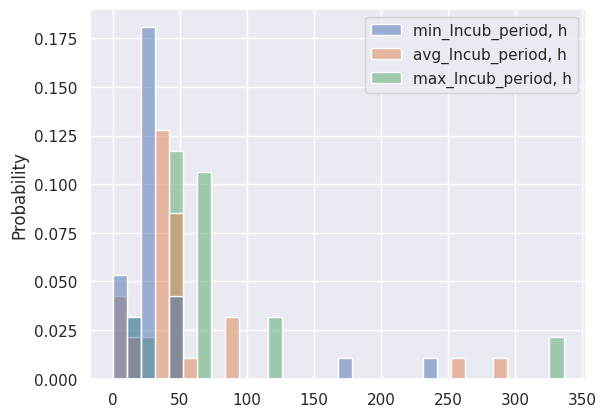

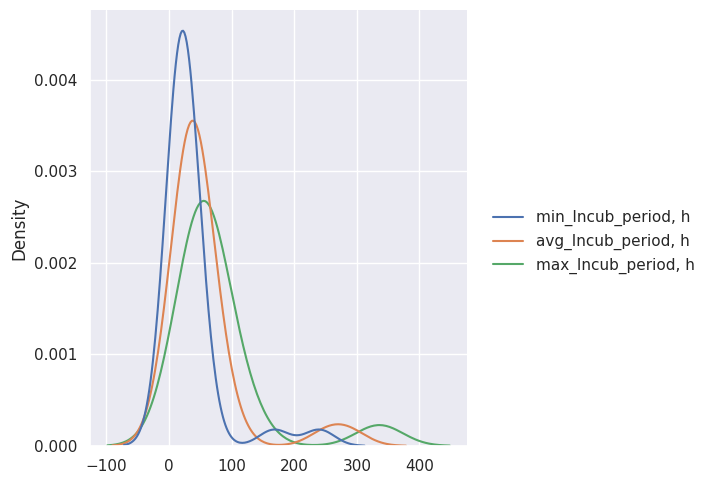

In [232]:
sns.histplot(data=df_bac[['min_Incub_period, h', 'avg_Incub_period, h', 'max_Incub_period, h']], stat='probability')

sns.displot(data=df_bac[['min_Incub_period, h', 'avg_Incub_period, h', 'max_Incub_period, h']], kind='kde')

In [233]:
df_bac[df_bac['min_Incub_period, h'].isna()]

,Bacteria,kingdom,phylum,class,order,family,genus,species,gram,"min_Incub_period, h","avg_Incub_period, h","max_Incub_period, h","growth_temp, C",biosafety_level,isolated_from
Tax_id,,,,,,,,,,,,,,,
['618'],Serratia odorifera,Bacteria,Pseudomonadota,Gammaproteobacteria,Enterobacterales,Yersiniaceae,Serratia,Serratia odorifera,n,NaN,0.00,NaN,30,1,soil


In [234]:
df_bac.loc[df_bac['min_Incub_period, h'].isna(), 'min_Incub_period, h'] = df_bac['min_Incub_period, h'].mode()[0]
df_bac.loc[df_bac['max_Incub_period, h'].isna(), 'max_Incub_period, h'] = df_bac['max_Incub_period, h'].mode()[0]
df_bac.loc[df_bac['avg_Incub_period, h'].isna(), 'avg_Incub_period, h'] = df_bac['avg_Incub_period, h'].mode()[0]

## Думаем над фичами

1. Три коррелирующих числа (min max и avg время инкубации) нам ни к чему, но можно посчитать "размах" - вдруг он окажется полезным

In [235]:
df_bac['min_max_Incub_period'] = df_bac['max_Incub_period, h'] - df_bac['min_Incub_period, h']
df_bac.drop(columns=['max_Incub_period, h', 'min_Incub_period, h'], inplace=True)
df_bac = df_bac.rename(columns={'avg_Incub_period, h': 'avg_Incub_period'})

Обнаружилась корреляция ```min_max_Incub_period``` с ```avg_Incub_period```, но график выглядит не так уж страшно линейным, поэтому попробуем.

<Axes: >

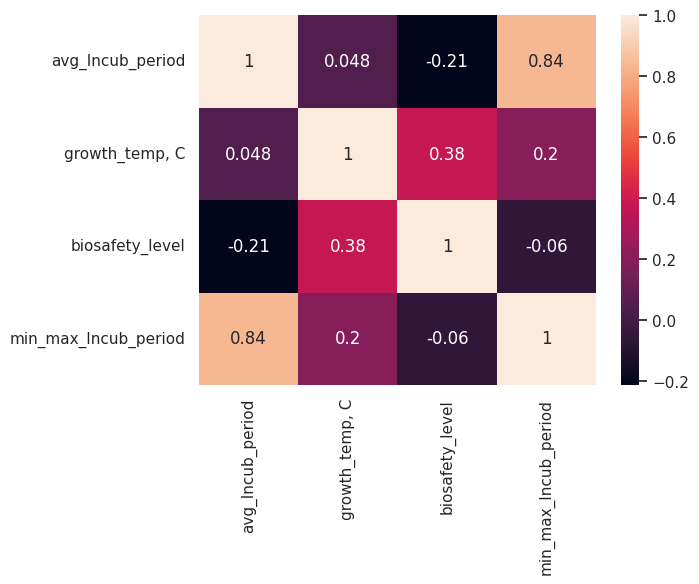

In [236]:
sns.heatmap(df_bac.corr(numeric_only=True), annot=True)

размах имеет слишком большую кореляцию, придется выкинуть :(

In [237]:
df_bac.drop(columns=['min_max_Incub_period'], inplace=True)

# 5 | Слияние трех баз данных в одну

In [238]:
df.drop_duplicates(inplace=True)
print(df.shape)


df = df.merge(df_bac, on='Bacteria', how='left')


df = df.merge(df_drug, on='Drug', how='left')


df.drop_duplicates(inplace=True)
print(df.shape)

(547, 14)
(547, 42)


In [239]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 547 entries, 0 to 546
Data columns (total 42 columns):
 #   Column                                       Non-Null Count  Dtype  
---  ------                                       --------------  -----  
 0   Bacteria                                     547 non-null    object 
 1   NP_Synthesis                                 547 non-null    object 
 2   Drug                                         547 non-null    object 
 3   Drug_class_drug_bank                         547 non-null    object 
 4   NP_concentration                             547 non-null    float64
 5   avg_NP_size                                  547 non-null    float64
 6   shape                                        547 non-null    object 
 7   method                                       547 non-null    object 
 8   ZOI_drug                                     533 non-null    float64
 9   ZOI_drug_NP                                  547 non-null    float64
 10  fo

# 6 | Добиваем NaNы

Для оставшихся (столбцы ```ZOI_drug, fold_increase.., lg_Drug_dose ```) применяем KNN, обучая его по всей таблице, за исключением систематики бактерий и класса препарата (слишком много лишних столбцов с учетом encoding).

Создадим дополнительную таблицу для обучения KNN

In [240]:
cols_to_drop = [
    'isolated_from', 'Smiles', 'species', 'genus', 'family', 'order', 'class',
    'phylum', 'kingdom', 'Drug_class_drug_bank'
]

df_dummy = deepcopy(df)
df_dummy = df_dummy.drop(columns=cols_to_drop)

df_dummy = pd.get_dummies(df_dummy, drop_first=True)

In [241]:
imp = KNNImputer()
df_dummy = imp.fit_transform(df_dummy)

df_dummy = pd.DataFrame(df_dummy, columns=imp.get_feature_names_out())

In [242]:
f'Total NaNs: {df_dummy.isna().sum().sum()}'

'Total NaNs: 0'

Пока что будем работать с df_dummy

# 7 | Выбросы, корреляции и анализ 

In [243]:
num_cols_final = deepcopy(num_cols)
num_cols_final.extend(descs_to_add)
num_cols_final.append('pKa')

<Axes: >

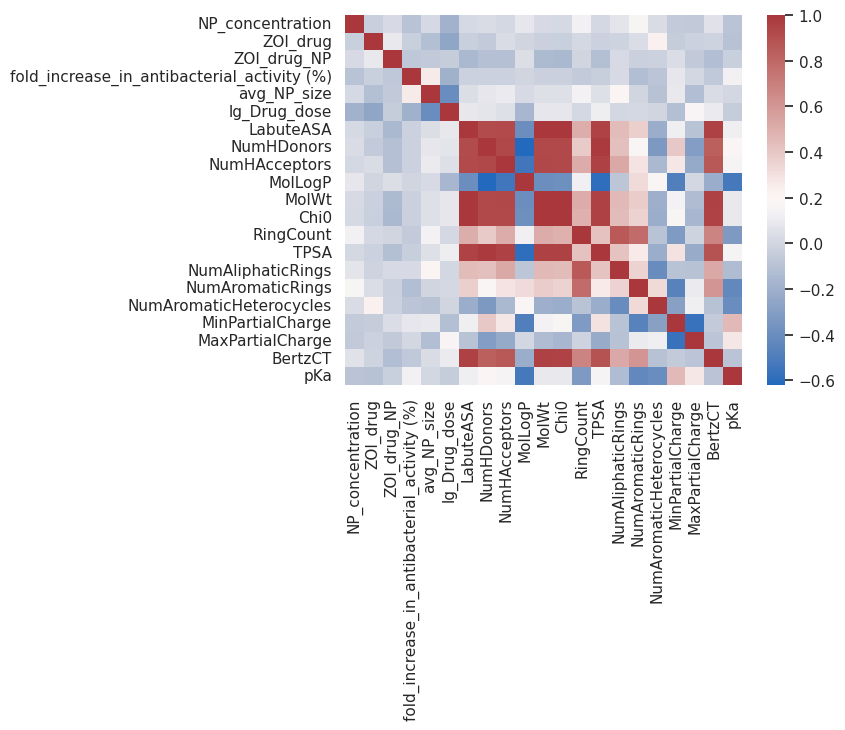

In [244]:
sns.heatmap(df_dummy[num_cols_final].corr(), cmap='vlag')
# df_dummy[num_cols_final].corr()[df_dummy[num_cols_final].corr() > 0.7]

--------------------------------! Внимание, медленная ячейка !-----------------------------

Сильно коррелируют столбцы дескрипторов, которые мы подгрузили. Перестарались, отменяем :)

In [245]:
last_drop = ['LabuteASA', 'MolWt', 'Chi0', 'NumHDonors', 'TPSA']
df_dummy.drop(columns=last_drop)
for col in last_drop:
    num_cols_final.remove(col)

<Axes: >

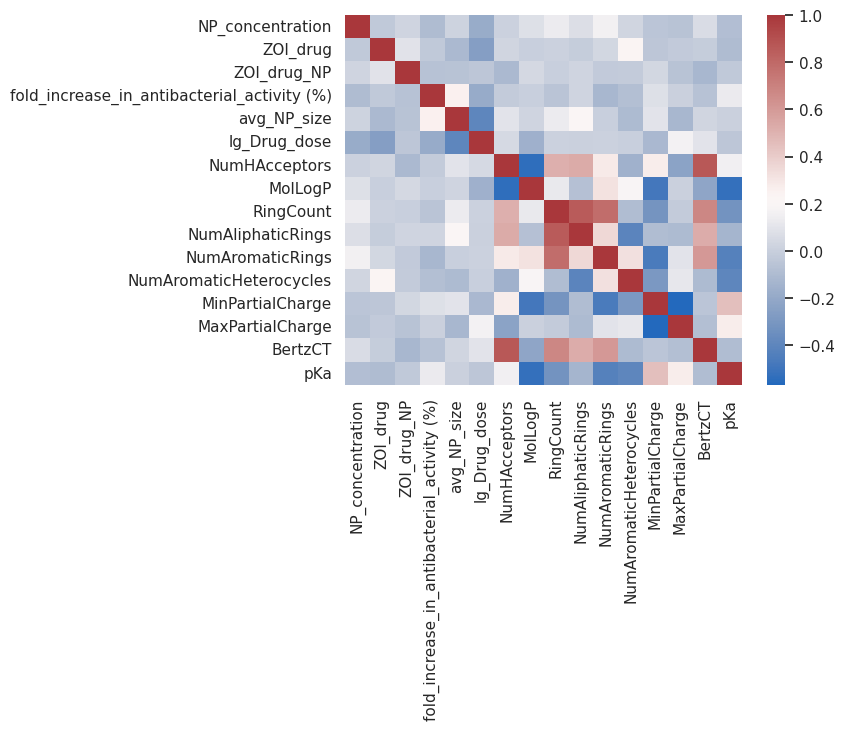

In [152]:
sns.heatmap(df_dummy[num_cols_final].corr(), cmap='vlag')

Красота! Остается посмотреть на распределения и pairplot

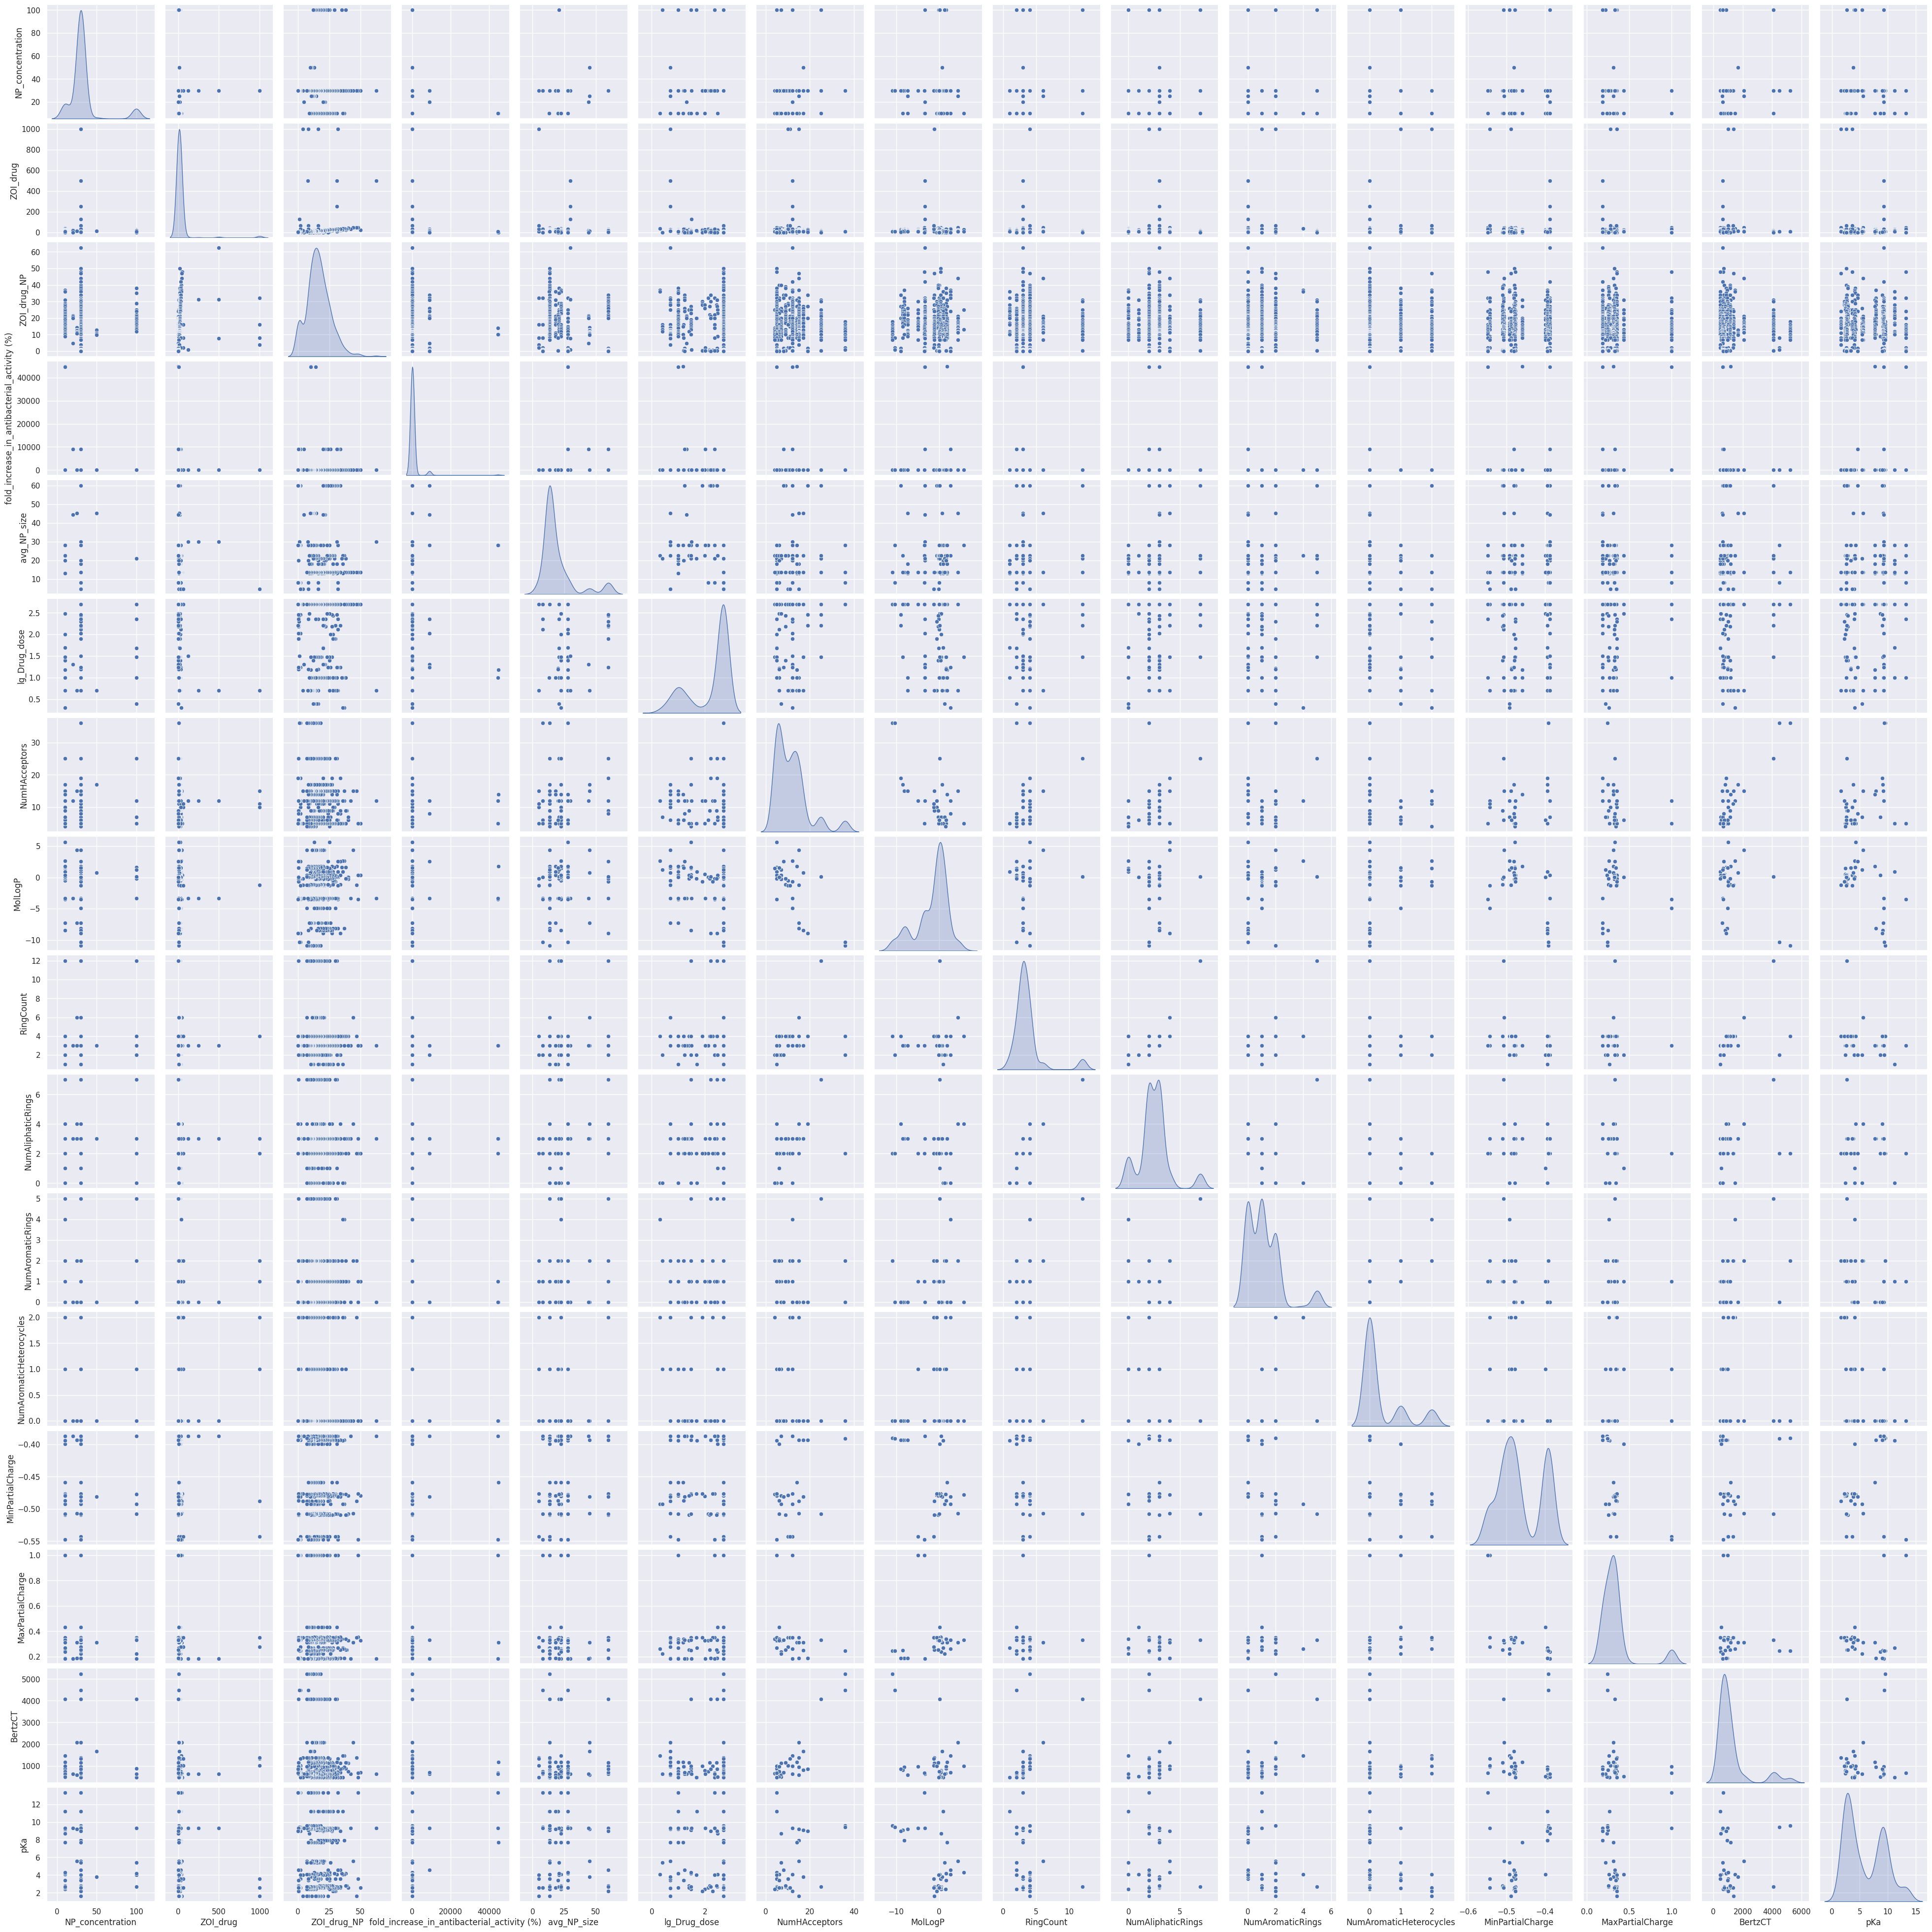

In [153]:
plot = sns.pairplot(df_dummy[num_cols_final], diag_kind='kde')
# plot.savefig('pairplot.png')

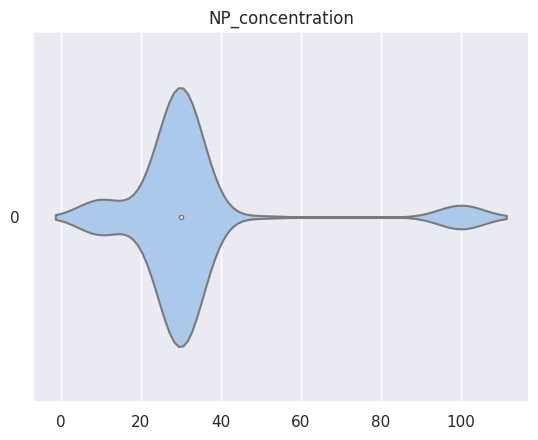

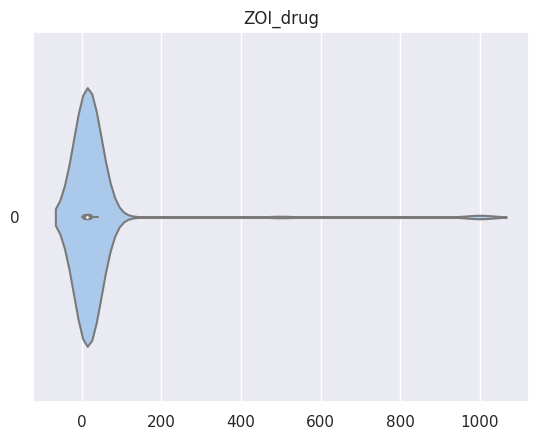

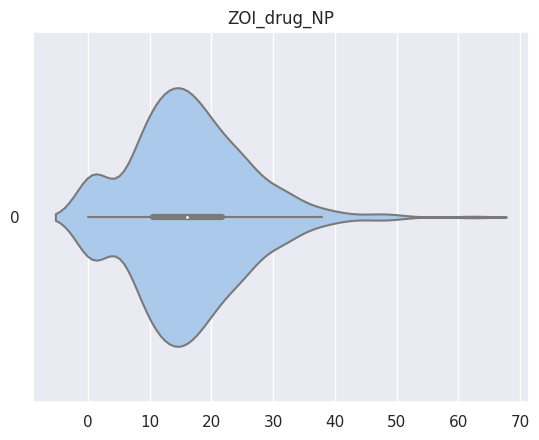

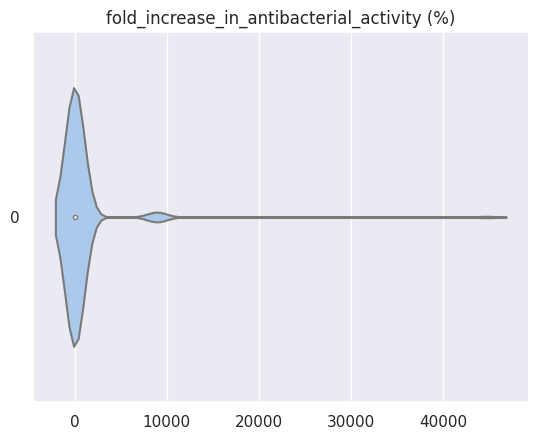

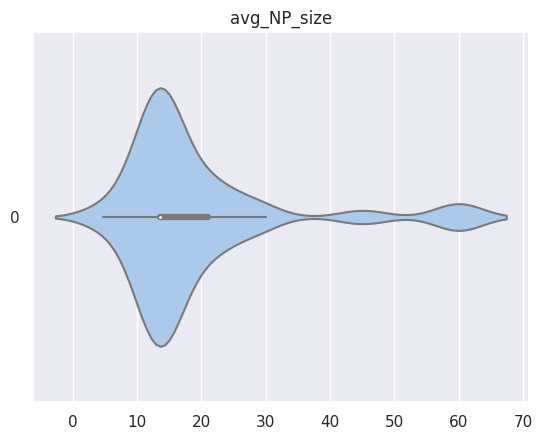

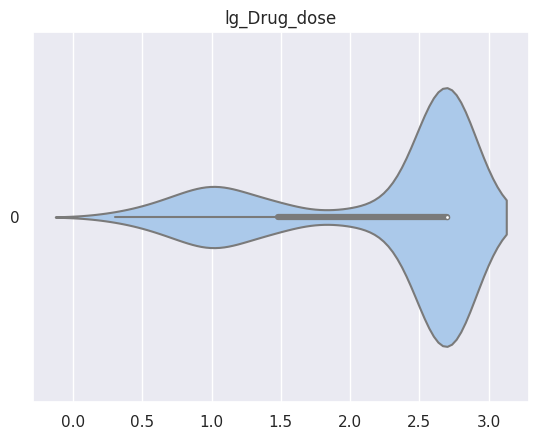

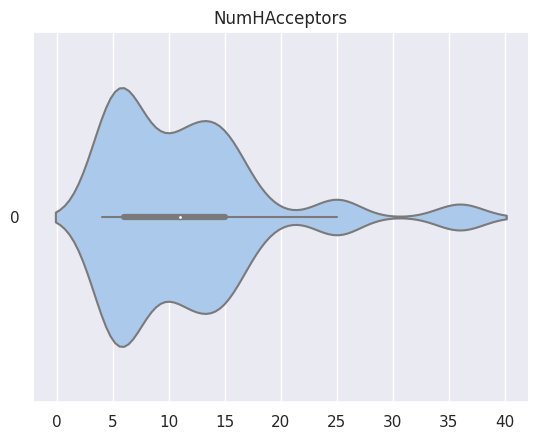

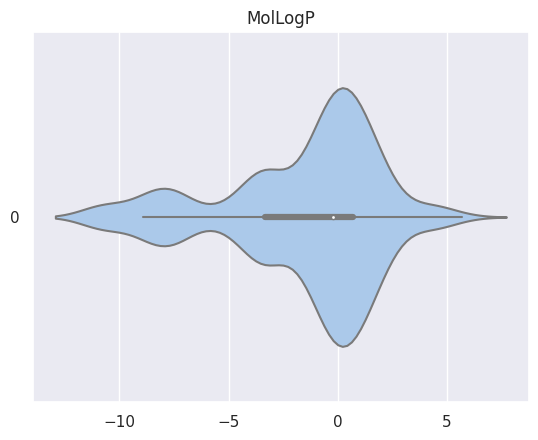

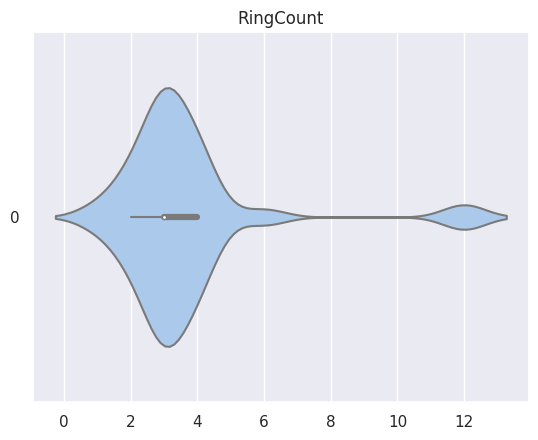

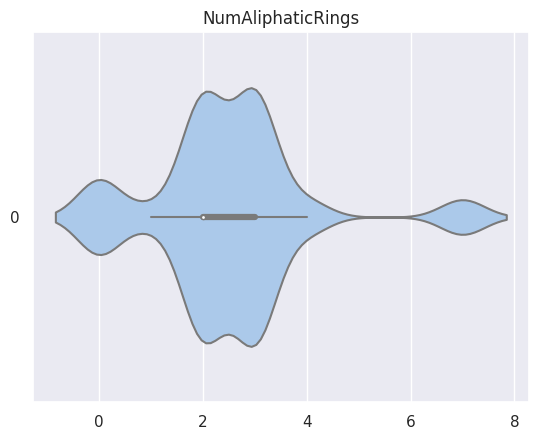

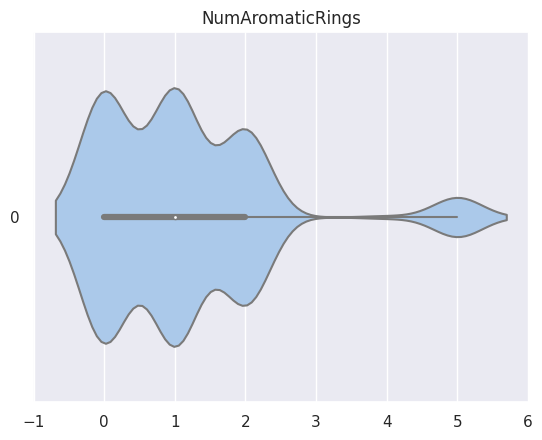

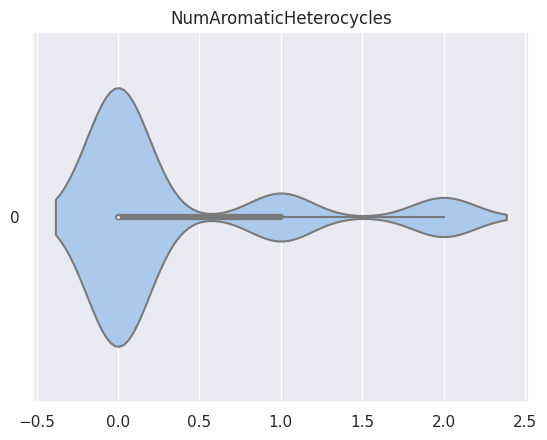

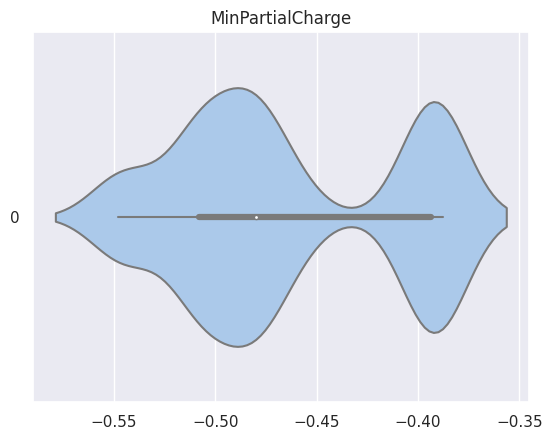

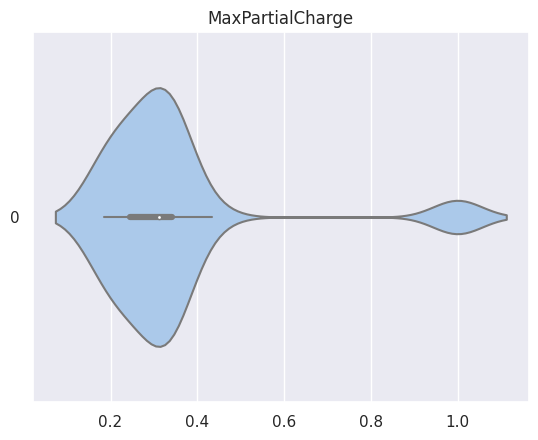

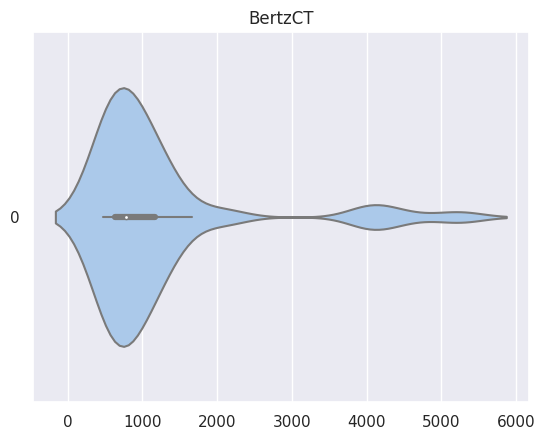

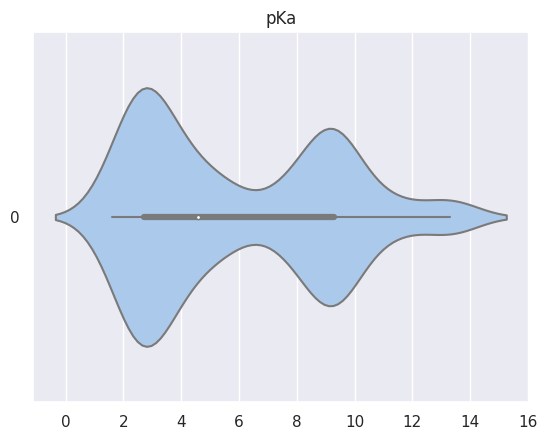

In [154]:
for col in num_cols_final:
    sns.violinplot(df_dummy[col], orient='h', width=0.7, palette='pastel')
    plt.title(col)
    plt.show()

Что-то странное с ```fold_increase``` и ```ZOI_drug```

In [246]:
for col, thresh in zip(['fold_increase_in_antibacterial_activity (%)', 'ZOI_drug'], [12, 80]):
    print(f'Column {col}, above {thresh}: {df_dummy[df_dummy[col] > thresh].shape[0]}')
    _med = df_dummy[col].median()
    df_dummy.loc[df_dummy[col] > thresh, col] = _med
    assert df_dummy[df_dummy[col] > thresh].shape[0] == 0

Column fold_increase_in_antibacterial_activity (%), above 12: 24
Column ZOI_drug, above 80: 12


Очистка данных закончена! Переносим в ```df``` столбцы, в которых мы заполняли дырки KNN-ом:

In [247]:
cols_to_fill = ['ZOI_drug', 'fold_increase_in_antibacterial_activity (%)', 'lg_Drug_dose']
df.loc[:, cols_to_fill] = df_dummy[cols_to_fill]
df.isna().sum().sum()

0

# 8 | Выбор ML-модели

## Encoding
Мы будем кодировать двумя способами и сравнивать результаты.

In [248]:
# Функция, кодирующая категориальные фичи в df с помощью 1) нумерации классов 2) one-hot. Возвращает оба варианта

def code_and_onehot(df: pd.DataFrame, cols_to_drop: list = []):
    ''' 
    Applies one-hod encoding and classes numeration for categorical features in df.
    
    Parameters
    ----------
    df: pandas Dataframe
        Columns are feature values
    cols_to_drop: list of strings
        Names of columns to drop before encoding
    
    Returns
    ----------
    (pd.DataFrame, pd.DataFrame)
        First one is the df with enumerated categorical features; second one is one-hot-encoded

    '''


    df_codes = deepcopy(df.drop(columns=cols_to_drop))
    df_onehot = deepcopy(df.drop(columns=cols_to_drop))

    for col in df.drop(columns=cols_to_drop):
        if df[col].dtype == object:
            df_codes[col] = pd.Categorical(df[col])
            df_codes[col] = df_codes[col].cat.codes

    df_onehot = pd.get_dummies(df_onehot, drop_first=True)
    
    return df_codes, df_onehot

In [249]:
cols_to_drop = ['Smiles']
df_codes, df_onehot = code_and_onehot(df, cols_to_drop)

df_nn = deepcopy(df_onehot)

## Подбор регрессионной модели

Воспользуемся модулем LazyRegressor, который проверит кучу классических ML-регрессоров с "как правило, хорошими" параметрами и предоставит отчет об их скорах.

In [159]:
reg = LazyRegressor(verbose=0, ignore_warnings=False, custom_metric=None)

for encoded_df, name in zip([df_codes, df_onehot], ['----- df_codes -----\n', '\n\n----- df_onehot -----\n']):
    print(f'{name}')
    X_train, X_test, y_train, y_test = train_test_split(
        encoded_df.drop(columns=['ZOI_drug_NP']), encoded_df['ZOI_drug_NP'], random_state=RANDOM_STATE,
        test_size=0.25    
    )
    models, predictions = reg.fit(X_train, X_test, y_train, y_test)
    print(models)

----- df_codes -----



100%|██████████| 42/42 [00:07<00:00,  5.80it/s]


                               Adjusted R-Squared  R-Squared  RMSE  Time Taken
Model                                                                         
ExtraTreesRegressor                          0.80       0.86  3.67        0.40
ExtraTreeRegressor                           0.76       0.83  4.00        0.02
GradientBoostingRegressor                    0.74       0.82  4.16        0.30
BaggingRegressor                             0.73       0.81  4.25        0.06
RandomForestRegressor                        0.73       0.81  4.26        0.48
XGBRegressor                                 0.72       0.80  4.32        0.18
LGBMRegressor                                0.72       0.80  4.35        0.07
HistGradientBoostingRegressor                0.71       0.80  4.40        0.30
LassoLarsIC                                  0.66       0.76  4.78        0.04
TransformedTargetRegressor                   0.66       0.76  4.79        0.02
LinearRegression                             0.66   

100%|██████████| 42/42 [00:12<00:00,  3.40it/s]

                                                              Adjusted R-Squared  \
Model                                                                              
Lars                          18643946356617191210558034818167019697278942745...   
RANSACRegressor                                   353177655828963171506323456.00   
TransformedTargetRegressor                        158896677629912040245035008.00   
LinearRegression                                  158896677629912040245035008.00   
SGDRegressor                                                            15826.08   
GaussianProcessRegressor                                                    8.64   
KernelRidge                                                                 6.70   
QuantileRegressor                                                           3.10   
DummyRegressor                                                              3.02   
NuSVR                                                                       

Пока что модели ExtraTreeRegressor (одно решающее дерево!) и ExtraTreesRegressor (ансамбль деревьев) лидируют по скору. Между one-hot-encoding и нумерацией классов разница несущественная, и R^2=0.86 

Проверим еще и CatBoost (в LazyPredict его нет). Заодно выясним, какие фичи являются ключевыми в моделях (25 наиболее важных признаков), оставим только их и проверим, насколько подрастёт скор.

In [160]:
def get_scores_by_models(
        models: list, df: pd.DataFrame, random_state=RANDOM_STATE, test_size=0.25, 
        get_features=True, plot_features=False
):
    
    ''' 
    Trains each model in models list, gets their scores and feature importances. Returns 25 best features and prints the scores.

    Parameters:
    -----------
    models: list of sklearn.Model objects
        Models to train and test.
    df: pd.DataFrame
        Training data (target column is hardcoded).
    get_features: bool
        Whether to return 25 most important features.
    plot_features: bool
        Whether to plot feature importance histogram
    '''

    X_train, X_test, y_train, y_test = train_test_split(
        df.drop(columns=['ZOI_drug_NP']), df['ZOI_drug_NP'], random_state=RANDOM_STATE,
        test_size=test_size    
    )
    
    list_best = []

    for model in models:
        pipe = Pipeline([('scaler', StandardScaler()), ('model', model)])
        pipe.fit(X_train, y_train)
        pred = pipe.predict(X_test)

        print(f'--- {pipe["model"].__class__.__name__} ---')
        print(f'R2 score: {r2_score(y_test, pred)}')
        print(f'RMSE score: {mean_squared_error(y_test, pred) ** 0.5}')

        if get_features or plot_features:

            feature_importance = pipe["model"].feature_importances_
            sorted_idx = np.argsort(feature_importance)

            if plot_features:
                plt.figure(figsize=(8, 8))
                plt.barh(range(len(sorted_idx[-25:])), feature_importance[sorted_idx[-25:]], align='center')
                plt.yticks(range(len(sorted_idx[-25:])), np.array(X_test.columns)[sorted_idx[-25:]])
                plt.title(f'Feature Importance for {pipe["model"].__class__.__name__}');
            
            best_features = np.array(X_test.columns)[sorted_idx[-25:]]
            list_best.extend(best_features)
        
    return list_best

In [161]:
ex_tree = ExtraTreesRegressor(random_state=RANDOM_STATE, n_jobs=-1)
cat = CatBoostRegressor(random_state=RANDOM_STATE, verbose=0)

models = [ex_tree, cat]
features = {}
final_datas = []

df_codes, df_onehot = code_and_onehot(df, cols_to_drop)

for encoded_df, name in zip([df_codes, df_onehot], ['----- df_codes -----\n', '\n\n----- df_onehot -----\n']):
    
    print(f'{name}')
    
    list_best = get_scores_by_models(models, encoded_df)
    
    list_best = list(set(list_best))
    print(f'Amount of important features for two model: {len(list_best)}')
    
    print(f'Scores after dropping non-important features')
    
    list_best.append('ZOI_drug_NP')
    encoded_df = encoded_df[list_best]
    final_datas.append(encoded_df)
    
    get_scores_by_models(models, encoded_df)

df_codes_final, df_onehot_final = final_datas

----- df_codes -----

--- ExtraTreesRegressor ---
R2 score: 0.8594592044951634
RMSE score: 3.6705543786658037
--- CatBoostRegressor ---
R2 score: 0.8337642938629183
RMSE score: 3.9920191412010992
Amount of important features for two model: 30
Scores after dropping non-important features
--- ExtraTreesRegressor ---
R2 score: 0.8711737899384475
RMSE score: 3.514249356389905
--- CatBoostRegressor ---
R2 score: 0.8281640025892536
RMSE score: 4.058705432293859


----- df_onehot -----

--- ExtraTreesRegressor ---
R2 score: 0.8697611048229199
RMSE score: 3.533465134919877
--- CatBoostRegressor ---
R2 score: 0.8320837658017698
RMSE score: 4.0121466770569985
Amount of important features for two model: 39
Scores after dropping non-important features
--- ExtraTreesRegressor ---
R2 score: 0.8624134594155501
RMSE score: 3.631770814693955
--- CatBoostRegressor ---
R2 score: 0.8213701218964172
RMSE score: 4.138162203171541


Если оставлять только самые важные признаки, ExtraTreesRegressor всё равно выигрывает CatBoost, и R^2 вырастает до 0.87.

## GridSearch для лучших моделей

Ищем лучшие наборы параметров для CatBoost и ExtraTreesRegressor

In [162]:
def make_gridsearchCV_by_models(models_params: list, df, test_size=0.25, cv=4, random_state=RANDOM_STATE):
    X_train, X_test, y_train, y_test = train_test_split(
        df.drop(columns=['ZOI_drug_NP']), df['ZOI_drug_NP'], random_state=random_state,
        test_size=test_size    
    )
    
    models = []
    for model in models_params:
        
        pipe = Pipeline([('scaler', StandardScaler()), ('model', model[0])])
        grid = GridSearchCV(pipe, model[1], scoring='r2', n_jobs=-1, cv=cv)
        grid.fit(X_train, y_train)

        print(f'--- Model: {pipe["model"].__class__.__name__} ---')
        print(f'Best params: {grid.best_params_}')
        print(f'Best CV R2 score: {grid.best_score_}')
        print(f'R2 score on unseen data: {r2_score(y_test, grid.best_estimator_.predict(X_test))}')
        
        models.append(grid.best_estimator_['model'])
    
    return models

In [163]:
cat = CatBoostRegressor(random_state=RANDOM_STATE, verbose=0)
cat_params = {
    'model__depth': [1, 2, 3],
    'model__iterations': [500, 1000, 3000],
    'model__learning_rate': [0.1, 0.3, 0.5], 
    'model__l2_leaf_reg': [0.5, 1, 3],
}


ex_tree = ExtraTreesRegressor(random_state=RANDOM_STATE, n_jobs=-1)
tree_params = {
    'model__max_depth': [10, 50, 100],
    'model__n_estimators': [75, 100, 150],
    'model__criterion': ['squared_error', 'absolute_error', 'friedman_mse'], 
    'model__min_samples_split': [2, 3, 4],
}

models_params = [
    [cat, cat_params],
    [ex_tree, tree_params]
]

best_models = []

for encoded_df, name in zip(
    [df_codes_final, df_onehot_final], 
    ['----- df_codes_final -----\n', '\n\n----- df_onehot_final -----\n']
):
    print(name)
    models = make_gridsearchCV_by_models(models_params, encoded_df, cv=4)
    best_models.append(models)

----- df_codes_final -----

--- Model: CatBoostRegressor ---
Best params: {'model__depth': 2, 'model__iterations': 3000, 'model__l2_leaf_reg': 0.5, 'model__learning_rate': 0.1}
Best CV R2 score: 0.8302632295836344
R2 score on unseen data: 0.8175265053067382
--- Model: ExtraTreesRegressor ---
Best params: {'model__criterion': 'absolute_error', 'model__max_depth': 50, 'model__min_samples_split': 2, 'model__n_estimators': 75}
Best CV R2 score: 0.8384901348930341
R2 score on unseen data: 0.8586916984443946


----- df_onehot_final -----

--- Model: CatBoostRegressor ---
Best params: {'model__depth': 2, 'model__iterations': 3000, 'model__l2_leaf_reg': 3, 'model__learning_rate': 0.1}
Best CV R2 score: 0.8220115947936402
R2 score on unseen data: 0.8259055537011964


KeyboardInterrupt: 

Смотрим на лучшие наборы параметров. Первый элемент списка - для кодирования кат. фичей номерами, второй - для one-hot.

In [ ]:
best_models

[]

Попробуем применить голосование (VotingRegressor) для CatBoost и ExtraTreesRegressor

In [ ]:
for group_models, encoded_df in zip(best_models, [df_codes_final, df_onehot_final]):
    vot = VotingRegressor([('cat', group_models[0]), ('ex_tree', group_models[1])], n_jobs=-1)
    get_scores_by_models([vot], encoded_df, get_features=False)

In [ ]:
# Визуализация работы VotingRegressor на лучших моделях с помощью LearningCurveDisplay
X, y = shuffle(df_onehot_final.drop(columns=['ZOI_drug_NP']), df_onehot_final['ZOI_drug_NP'], random_state=RANDOM_STATE)
fig, ax = plt.subplots(figsize=(10, 6))
pipe = Pipeline([('scaler', RobustScaler()), ('model', vot)])
LearningCurveDisplay.from_estimator(
    pipe, X=X, y=y,
    ax=ax, n_jobs=-1, 
)
handles, label = ax.get_legend_handles_labels()
ax.legend(handles[:2], ["Training Score", "Test Score"])
ax.set_title(f"Learning Curve for {pipe['model'].__class__.__name__}");

NameError: name 'random_state' is not defined

# 9 | Обучаем нейросеть
Для этой задачи мы построим полносвязную нейронную сеть на PyTorch. Особо перебирать архитектуру не будем, пара заметок - не нужно делать очень уж глубокую сеть, поскольку датасет маленький: если будет адекватный скор - уже хорошо.

## Загрузка и предобработка данных

In [250]:
df = df_nn

X = torch.tensor(df.drop(columns=['ZOI_drug_NP']).astype('float32').to_numpy())
y = torch.tensor(df['ZOI_drug_NP'].astype('float32').to_numpy().reshape(-1, 1))

Данные нужно отмасштабировать, чтобы градиенты не взрывались

In [251]:
scaler = MinMaxScaler()
scaler.fit_transform(X, y)

array([[2.22222222e-01, 5.96745060e-02, 5.00000000e-01, ...,
        0.00000000e+00, 1.00000000e+00, 0.00000000e+00],
       [2.22222222e-01, 5.96745060e-02, 5.00000000e-01, ...,
        0.00000000e+00, 1.00000000e+00, 0.00000000e+00],
       [2.22222222e-01, 4.21338158e-01, 5.00000000e-01, ...,
        0.00000000e+00, 1.00000000e+00, 0.00000000e+00],
       ...,
       [2.22222222e-01, 5.96745060e-02, 4.68749990e-04, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [2.22222222e-01, 4.21338158e-01, 4.68749990e-04, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [2.22222222e-01, 1.00000000e+00, 3.90625000e-02, ...,
        0.00000000e+00, 1.00000000e+00, 0.00000000e+00]])

Делим на тест и трейн

In [252]:
X, X_test, y, y_test = train_test_split(X, y, test_size=0.07)
print(f'Train: {X.shape[0]}, test: {X_test.shape[0]}')
print(f'Features: {X.shape[1]}')

Train: 508, test: 39
Features: 204


## Модель

Попробуем небольшую модель с одним скрытым слоем, в котором нейронов будет втрое меньше, чем на входе. После входного и скрытого слоев будет функция активации: по дефолту поставим ReLU(x) = max(0, x), а потом подберем лучшую.

Дропаут - это защита от переобучения. При применении дропаута ```0 <= w * 100% <= 100%``` нейронов деактивируется, ```w``` - аргумент ```nn.Dropout()```. Сначала исследуем модель без него, лучшие параметры применим для модели с дропаутом. 

In [261]:
class DenseNN(nn.Module):
    def __init__(self, in_features: int, activation=F.relu, do_dropout=False):
        super(DenseNN, self).__init__()
        self.activation = activation
        self.fc1 = nn.Linear(in_features, in_features)
        self.fc2 = nn.Linear(in_features, in_features // 3)
        self.fc3 = nn.Linear(in_features // 3, 1)
        self.do_dropout = do_dropout
        self.dropout = nn.Dropout(0.1)

    def forward(self, x):
        x = self.activation(self.fc1(x))
        
        if self.do_dropout:
            x = self.dropout(x)

        x = self.activation(self.fc2(x))
        
        if self.do_dropout:
            x = self.dropout(x)        
        
        x = self.fc3(x)
        return x

## Обучаем модель

Лосс - MSE как стандарт для регрессии, оптимизация Adam либо SGD

In [276]:
def test_model(loss_fn_name=nn.MSELoss, 
               optimizer_lr=(torch.optim.Adam, 1.5e-3),
               n_epochs=100,
               batch_size=6,
               activation_name=F.relu,
               do_dropout=False,
               verbose=True,
               mode='last'):
    ''' 
    Performs DenseNN model training, including r2-scoring on test data every epoch 
    Parameters:
    -----------
    loss_fn_name: nn.Module
    optimizer_lr: tuple(nn.Module, float)
    n_epochs: int
    batch_size: int
    activation_name: nn.Module
    do_dropout: bool
        Whether to use dropout
    verbose: bool
        If True, prints every epoch; no output if False
    mode: str 'last' or 'best'
        Function returns last state of model if 'last', returns model with best r^2 score if 'best'
    
    Returns
    -------
    (model, history_loss, history_r2): tuple of DenseNN(nn.Module), list, list
        Best trained model, loss and r2 scores for each epoch 
    '''

    model = DenseNN(X.shape[1], activation=activation_name, do_dropout=do_dropout)
    loss_fn = loss_fn_name()
    optimizer = optimizer_lr[0](model.parameters(), lr=optimizer_lr[1])

    history_loss = []
    history_r2 = []
    model_best = None

    for n_epoch in range(n_epochs):
        for i in range(0, len(X), batch_size):
            Xbatch = X[i:i+batch_size]
            
            y_pred = model(Xbatch)
        
            ybatch = y[i:i+batch_size]

            loss = loss_fn(y_pred, ybatch)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
        
        history_loss.append(loss.item())
        history_r2.append(r2_score(y_test.detach().numpy(), model(X_test).detach().numpy()))
        
        if verbose:
            print(f'Finished epoch {n_epoch + 1}/{n_epochs}, latest loss {history_loss[-1]:.3f}, R^2 on test {history_r2[-1]:.3f}')
        
        if history_r2[-1] == max(history_r2):
            model_best = deepcopy(model)
    
    model_to_return = model_best if mode == 'best' else model
    return model_best, history_loss, history_r2

Finished epoch 1/100, latest loss 14.147, R^2 on test -0.317
Finished epoch 2/100, latest loss 10.078, R^2 on test 0.015
Finished epoch 3/100, latest loss 7.512, R^2 on test 0.104
Finished epoch 4/100, latest loss 15.732, R^2 on test -0.027
Finished epoch 5/100, latest loss 8.990, R^2 on test 0.005
Finished epoch 6/100, latest loss 7.125, R^2 on test -0.042
Finished epoch 7/100, latest loss 10.134, R^2 on test -0.064
Finished epoch 8/100, latest loss 7.148, R^2 on test -0.039
Finished epoch 9/100, latest loss 8.196, R^2 on test -0.028
Finished epoch 10/100, latest loss 6.730, R^2 on test 0.005
Finished epoch 11/100, latest loss 6.797, R^2 on test 0.008
Finished epoch 12/100, latest loss 6.099, R^2 on test 0.040
Finished epoch 13/100, latest loss 4.981, R^2 on test 0.072
Finished epoch 14/100, latest loss 4.577, R^2 on test 0.082
Finished epoch 15/100, latest loss 2.399, R^2 on test 0.115
Finished epoch 16/100, latest loss 3.018, R^2 on test 0.106
Finished epoch 17/100, latest loss 1.77

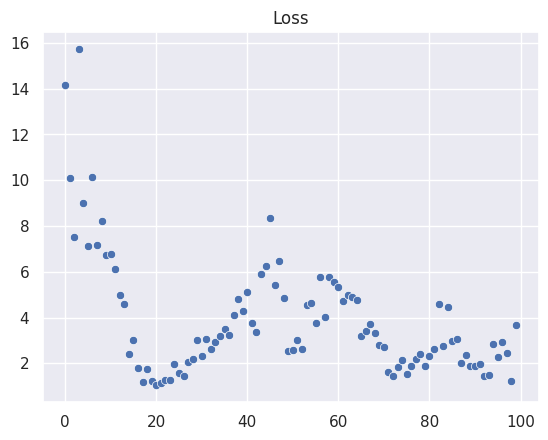

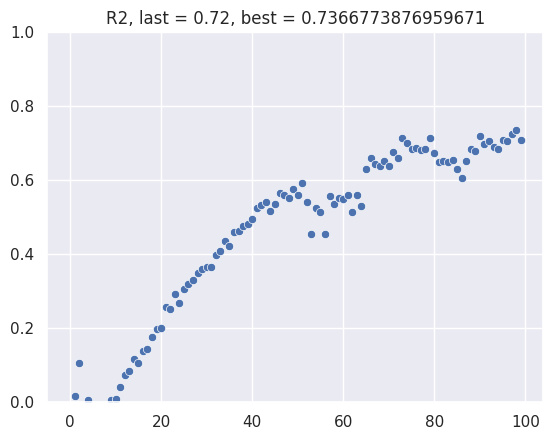

In [277]:
model, history_loss, history_r2 = test_model()

sns.scatterplot(history_loss)
plt.title('Loss')
plt.show()
sns.scatterplot(history_r2)
plt.title(f'R2, last = {round(r2_score(y_test.detach().numpy(), model(X_test).detach().floor().numpy()), 3)}, best = {max(history_r2)}')
plt.ylim(0, 1)
plt.show()

## Подбор лучших параметров
Сделаем простейший гридсёрч с помощью итератора

In [278]:
def get_params(param_list_1, param_list_2=None, param_list_3=None, param_list_4=None, param_list_5=None):
    ''' 
    Parameters:
    -----------
    param_list_i: list
        Parameters to choose from. If unset or None, not used in grid

    Yields:
    -----------
    (param_1, param_2, ...): tuple, len = 5
        Grid of parameters 

    '''
    
    for param_1 in param_list_1:
        if param_list_2:
            for param_2 in param_list_2:
                if param_list_3:
                    for param_3 in param_list_3:
                        if param_list_4:
                            for param_4 in param_list_4:
                                if param_list_5:
                                    for param_5 in param_list_5:
                                        yield param_1, param_2, param_3, param_4, param_5
                                else:
                                    yield param_1, param_2, param_3, param_4, None
                        else:
                            yield param_1, param_2, param_3, None, None
                else:
                    yield param_1, param_2, None, None, None
        else:
            yield param_1, None, None, None, None

In [279]:
optimizers = [(torch.optim.Adam, 1.5e-3), (torch.optim.SGD, 5e-5)]
activations = [F.relu, F.elu, F.leaky_relu, torch.sigmoid]
dropout_modes = [False, True]
ns_epochs = [50, 75, 100, 200, 500]

best_combination = (None, 0.0, '', '', False, 0) # model, r2 score, opt, act, drop, n_ep

for optimizer, activation, dropout_mode, n_epochs, _ in get_params(optimizers, activations, dropout_modes, ns_epochs):
    model, history_loss, history_r2 = test_model(optimizer_lr=optimizer, 
                                                 n_epochs=n_epochs, 
                                                 activation_name=activation, 
                                                 do_dropout=dropout_mode,
                                                 verbose=False)
    print('-------------------------')
    print(f'''Params:
                optimizer ....... {optimizer[0].__name__},
                activation ...... {activation.__name__},
                do dropout ...... {dropout_mode},
                epochs .......... {n_epochs}
          ''')
    print(f'Max R2: {max(history_r2):.4f}, last R2: {history_r2[-1]:.4f}')

    if max(history_r2) > best_combination[1]:
      best_combination_repr = model.__repr__, max(history_r2), optimizer[0].__name__, activation.__name__, dropout_mode, n_epochs
      best_combination = model, max(history_r2), optimizer, activation, dropout_mode, n_epochs

print(f'[FINISHED]\nOverall best: {best_combination_repr}')

print(f'Training this model')
_, __, best_optimizer, best_activation, best_dropout_mode, best_n_epochs = best_combination 
best_model, history_loss, history_r2 = test_model(optimizer_lr=best_optimizer, 
                                                 n_epochs=best_n_epochs, 
                                                 activation_name=best_activation, 
                                                 do_dropout=best_dropout_mode,
                                                 verbose=True,
                                                 mode='best')

-------------------------
Params:
                optimizer ....... Adam,
                activation ...... relu,
                do dropout ...... False,
                epochs .......... 50
          
Max R2: 0.5139, last R2: 0.5139
-------------------------
Params:
                optimizer ....... Adam,
                activation ...... relu,
                do dropout ...... False,
                epochs .......... 75
          
Max R2: 0.6735, last R2: 0.6290
-------------------------
Params:
                optimizer ....... Adam,
                activation ...... relu,
                do dropout ...... False,
                epochs .......... 100
          
Max R2: 0.6809, last R2: 0.6809
-------------------------
Params:
                optimizer ....... Adam,
                activation ...... relu,
                do dropout ...... False,
                epochs .......... 200
          
Max R2: 0.6524, last R2: 0.3523
-------------------------
Params:
                optimize

KeyboardInterrupt: 

Результаты обучения см. в nn_dump.txt. SGD очень медленно обучался, а при повышении lr градиенты взрывались.

Лучшие параметры:
Adam, elu, с дропаутом, чуть меньше чем 200 эпох. ```R^2 = 0.9125``` !!!!!

Finished epoch 1/200, latest loss 151.786, R^2 on test 0.139
Finished epoch 2/200, latest loss 628.729, R^2 on test -0.068
Finished epoch 3/200, latest loss 98.567, R^2 on test -0.059
Finished epoch 4/200, latest loss 146.159, R^2 on test -0.470
Finished epoch 5/200, latest loss 41.796, R^2 on test -0.253
Finished epoch 6/200, latest loss 174.522, R^2 on test -0.150
Finished epoch 7/200, latest loss 74.268, R^2 on test 0.010
Finished epoch 8/200, latest loss 58.580, R^2 on test -0.201
Finished epoch 9/200, latest loss 63.554, R^2 on test 0.061
Finished epoch 10/200, latest loss 60.124, R^2 on test 0.121
Finished epoch 11/200, latest loss 46.973, R^2 on test 0.259
Finished epoch 12/200, latest loss 86.689, R^2 on test 0.158
Finished epoch 13/200, latest loss 62.032, R^2 on test 0.460
Finished epoch 14/200, latest loss 15.605, R^2 on test 0.306
Finished epoch 15/200, latest loss 32.463, R^2 on test 0.319
Finished epoch 16/200, latest loss 42.304, R^2 on test 0.206
Finished epoch 17/200, 

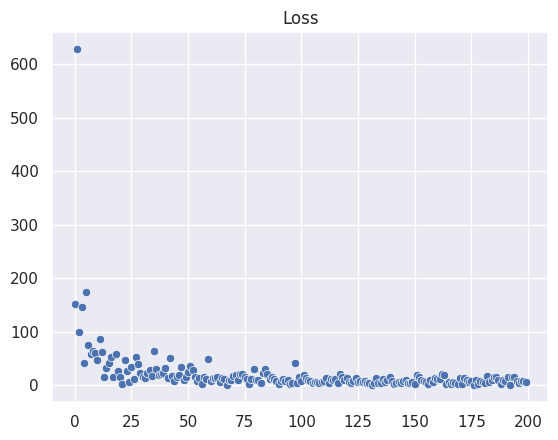

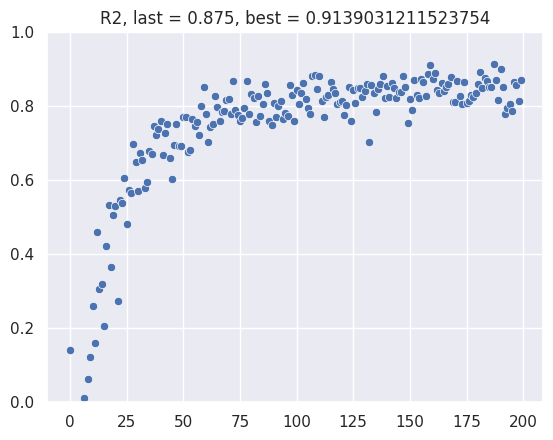

In [189]:
model, history_loss, history_r2 = test_model(optimizer_lr=(torch.optim.Adam, 2.5e-4), 
                                                 n_epochs=200, 
                                                 activation_name=F.elu, 
                                                 do_dropout=True,
                                                 verbose=True)

sns.scatterplot(history_loss)
plt.title('Loss')
plt.show()
sns.scatterplot(history_r2)
plt.title(f'R2, last = {round(r2_score(y_test.detach().numpy(), model(X_test).detach().floor().numpy()), 3)}, best = {max(history_r2)}')
plt.ylim(0, 1)
plt.show()